In [55]:
import csv
import plotly.offline as py
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms import community

## Load PPI edges

In [15]:
ppi_edges_dict = {}

# Append BioGRID data to edge dict
with open("BioGRID.sig", "r") as file:
    for line in file.read().split("\n"):
        data = [ x for x in line.split() if x != "NA" ]
        if len(data) != 3:
            continue
        if data[0] in ppi_edges_dict:
            ppi_edges_dict[data[0]].add(data[1])
        else:
            ppi_edges_dict[data[0]] = set([data[1]])
    file.close()

In [16]:
# Append iREF data to edge dict
with open("iREF.sig","r") as file:
    for line in file.read().split("\n"):
        data = line.split()
        if len(data) != 13:
            continue
        if any([ data[-2] in x for x in ["physical_association", "direct_interaction"] ]):
            if data[0] in ppi_edges_dict:
                ppi_edges_dict[data[0]].add(data[5])
            else:
                ppi_edges_dict[data[0]] = set([data[5]])

In [17]:
# compile a list of all the edges as tuples
ppi_edges_list = []
for i,v in ppi_edges_dict.items():
    for g in v:
        ppi_edges_list.append((i,g))
    
print(len(ppi_edges_list))

66590


In [18]:
# write the resulting list to a file
with open("edges_list.csv","w") as f_out:
    writer = csv.writer(f_out, delimiter=',', lineterminator='\n')
    writer.writerows(ppi_edges_list)

## Load gene-gene coexpression edges

In [6]:
df = pd.read_feather("human_correlation_feather")
print(df.shape)
df.head()

(26415, 26415)


,A1BG,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,AACSP1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,1.000000,0.311017,0.074197,0.011767,0.015465,-0.083539,0.024190,-0.023043,0.116815,0.005853,...,-0.020775,-0.065653,-0.034081,-0.002724,-0.022020,0.101489,0.020808,-0.093609,-0.025960,0.003271
1,0.311017,1.000000,0.314577,-0.001876,-0.000682,-0.065426,0.020387,-0.047918,0.046401,-0.004944,...,-0.079724,-0.071680,-0.018917,0.047886,0.003180,0.002353,-0.007614,-0.086449,0.018525,0.003854
2,0.074197,0.314577,1.000000,-0.028479,-0.017056,0.014158,0.014082,-0.021786,-0.059868,-0.022951,...,-0.097068,-0.067448,0.001960,0.018967,0.046186,-0.111606,-0.013873,0.028855,0.021196,-0.037100
3,0.011767,-0.001876,-0.028479,1.000000,0.007315,0.038877,-0.005643,-0.024810,0.058989,0.031632,...,-0.021674,-0.047888,0.005581,0.009300,-0.008702,0.031462,0.013790,-0.055190,0.001249,0.018487
4,0.015465,-0.000682,-0.017056,0.007315,1.000000,-0.035422,-0.008135,-0.002369,-0.003118,0.011400,...,-0.039716,-0.023186,0.007086,-0.010465,0.026512,0.061912,0.003802,-0.027152,0.010331,0.035132


In [7]:
# create array of gene names
names = df.columns.tolist()

# initialize dict
top_corr = {}

for i in range(len(names)):
    col = df[names[i]]
    col.index = names
    col = col.sort_values(ascending=False)
    top = [ x for x in col.index.values[0:6] if x != names[i] ]
    top_corr[names[i]] = top

In [8]:
df_top = pd.DataFrame(top_corr)
df_top.to_csv("top_correlation.csv", encoding='utf-8', index=False)
df_top.head()

,A1BG,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,AACSP1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,ITIH1,PAH,ITIH2,PPL,ARRDC5,ALPPL2,METTL7B,SNRPA,SLC35E3,TP53I13,...,CSE1L,MCM6,YBX1P4,CPS1,NSA2,CA5A,PPP1R3A,GNAI2,GAREM1,MAP2K6
1,AGXT,SLC2A2,AHSG,TGM1,RP11.927P21.9,KLRG2,SSTR5,RUVBL2,PEX26,RENBP,...,NPM1,TIMELESS,RP11.475I24.1,CKAP2P1,CICP27,FAM98C,TXLNB,TGFB1,DHRS12,HSBP1
2,CYP4A11,CPB2,IGFBP1,KLK13,CSPG4P11,FGF4,C2ORF82,PLK1,ZNF793,PRRT4,...,RAN,SAA3P,REM2,GLP2R,RPL10AP5,PCDHB1,TRDN,PXN,ATP5LP3,POT1
3,C8B,APOH,ITIH3,SCEL,SMIM2,NLRP7,KLHL4,CDC20,RPS6KA5,PPOX,...,LDHB,PSMC5,RP5.1147A1.1,RP11.91J3.1,RPL21P3,USHBP1,XIRP2,VASP,GPR162,SNRPGP14
4,SLC25A47,ALB,AGT,KRT78,RP11.123K3.4,DNMT3L,SPIC,KIF22,ZNF556,AQP7P1,...,PAICS,RFC3,SMCR8,MTNR1A,RPL37P1,ZBTB8B,PYGM,SPI1,RPL27A,GOLGA2P2Y


In [21]:
gene_edges_dict = df_top.to_dict('list')

In [23]:
def get_relevant_ppi_edges(gene_list):
    edges = []
    for gene in gene_list:
        if gene in ppi_edges_dict:  
            edges = [*edges,  *[(gene, x) for x in ppi_edges_dict[gene]]]
    return edges

def get_relevant_gene_edges(gene_list):
    edges = []
    for gene in gene_list:
        if gene in gene_edges_dict:  
            edges = [*edges,  *[(gene, x) for x in gene_edges_dict[gene]]]
    return edges

In [24]:
# Load a sample gene list
sample_genes = []

with open("ULK4_293_coIP_hits.txt","r") as f_in:
    writer = csv.reader(f_in, lineterminator='\n')
    sample_genes = [item for sublist in writer for item in sublist if len(sublist) > 0]
    sample_genes = [*sample_genes]

sample_gene_list = [ x.upper() for x in sample_genes ]
ppi_edges = get_relevant_ppi_edges(sample_gene_list)
gene_edges = get_relevant_gene_edges(sample_gene_list)


In [51]:
G = nx.Graph()
G.add_nodes_from(sample_genes)
G.add_edges_from(ppi_edges)
G.add_edges_from(gene_edges)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3032
Number of edges: 4703
Average degree:   3.1022


In [65]:
c = list(k_clique_communities(G, 3))
for clique in c:
    print("\n".join(list(clique)), "\n\n")

ILF2
NUP93
YTHDF2
RAN 


AARS2
DHX37
MYBBP1A
PGAM5 


TMEM201
MYBBP1A
EIF4G1
PTBP1
KSR1
GEMIN4 


BUB1
NUP160
SHC1
CRK
UBC
SYK
WNK3
GAB2
TP53
REV1
NUP98
MAGED1
DNAAF5
HNRNPUL1
RMDN3
MCM4
IRS1
NUP205
TERF1
NCAPH
HNRNPU
LATS2
TOP2A
BSG
TNPO3
BRCA1
AIFM1
FANCL
RPS27A
GCK
IRAK2
CRKL
ICMT
SEC13
IPO5
CHEK1
NUP107
WNK4
NT5DC2
SEC16A
PSME1
LMNB2
PRKCD
LTK
ARAF
POLD1
SOS1
BLNK
YWHAB
IPO7
RASSF1
MDM2
STK4
NEK6
LRPPRC
GTF3C4
SLC38A1
PAICS
NUP214
RAN
JAK1
ANAPC7
ERBB2
PDGFRB
MAP3K7
EGFR
RPL30
PRKAR1A
PIK3R1
IRAK1
TPX2
SH3KBP1
CHUK
NTRK1
KHSRP
TUBG1
ABL1
IKBKB
NUP85
MAP3K3
GRB2
PTK2
PTPRA
PPM1G
PTTG1
CDC20
SMC4
STK3
NUP37
MAPKAPK2
PTBP1
BCAR1
PPP2R1A
BRAF
SMPD4
CLU
VAV1
NCAPD2
PMS2
MAP2K7
DARS2
KPNB1
FAR1
TRIM28
HSP90AA1
SGK1
RAF1
TRAF6
AHCTF1
PRKDC
PLK1
HSP90AB1
ASPM
MLH1
CTNNB1
ATR
PXN
MCM2
MAP3K1
LMNB1
MCM3
PDS5A
XPO5
PTPN11
KIFC1
SMC2
PCNA
ZWINT
FANCD2
HSPA4
CENPB
NUP133
NUP88
INCENP
BRCA2
MSH6
STUB1
MCM7
RIPK2
JAK3
GAB1
FYN
FANCI
RAE1
VAV3
AKT1
MSH2
XRCC5
LATS1
CBL
XPOT
ESR1
JAK2
CIP2A
XIAP
XP

In [87]:
cluster_coeff = nx.clustering(G)

df_cluster = pd.Series(cluster_coeff)
df_cluster = df_cluster.sort_values(ascending=False)
df_cluster = df_cluster.to_frame()

df_cluster.head(10)

,0
HERPUD1,1.0
SLC45A2,1.0
RPL30,1.0
WNK3,1.0
PMS2,1.0
USP16,1.0
SNCB,1.0
PABPC1,1.0
HIST1H3A,1.0
XBP1,1.0


In [89]:
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted(map(sorted, next_level_communities))

[['A2M',
  'AAK1',
  'AAR2',
  'AARS',
  'AARS2',
  'AARSD1',
  'AATF',
  'ABCA1',
  'ABCA2',
  'ABCB10P4',
  'ABCB6',
  'ABCD1',
  'ABCE1',
  'ABHD12',
  'ABHD17AP1',
  'ABHD17AP6',
  'ABL1',
  'ABL2',
  'ABTB1',
  'AC000367.1',
  'AC006116.13',
  'AC007318.5',
  'AC008834.2',
  'AC090094.1',
  'AC093162.5',
  'AC096582.9',
  'ACAA1',
  'ACACA',
  'ACAD9',
  'ACAP3',
  'ACAT2',
  'ACIN1',
  'ACLY',
  'ACO2',
  'ACOT9',
  'ACOX1',
  'ACSL3',
  'ACSL4',
  'ACSS2',
  'ACTA1',
  'ACTB',
  'ACTG2',
  'ACTN1',
  'ACTN4',
  'ACTR2',
  'ACY3',
  'ADAM1A',
  'ADAM2',
  'ADAM8',
  'ADAM9',
  'ADCK1',
  'ADCK5',
  'ADGRE5',
  'ADRB2',
  'ADRM1',
  'AF196972.4',
  'AFG3L2',
  'AGER',
  'AGK',
  'AGO4',
  'AGPAT2',
  'AGT',
  'AHCTF1',
  'AHCY',
  'AHNAK',
  'AHSG',
  'AIFM1',
  'AJUBA',
  'AK5',
  'AKAP1',
  'AKAP10',
  'AKAP8L',
  'AKR1B1',
  'AKT1',
  'AKT1S1',
  'AKT2',
  'AL023806.1',
  'ALDH1A2',
  'ALDH3A2',
  'ALDH4A1',
  'ALDOA',
  'ALG1',
  'ALKBH6',
  'ALOX5',
  'ALPK2',
  'ALYREF',
  '

In [91]:
print(map(sorted, top_level_communities))

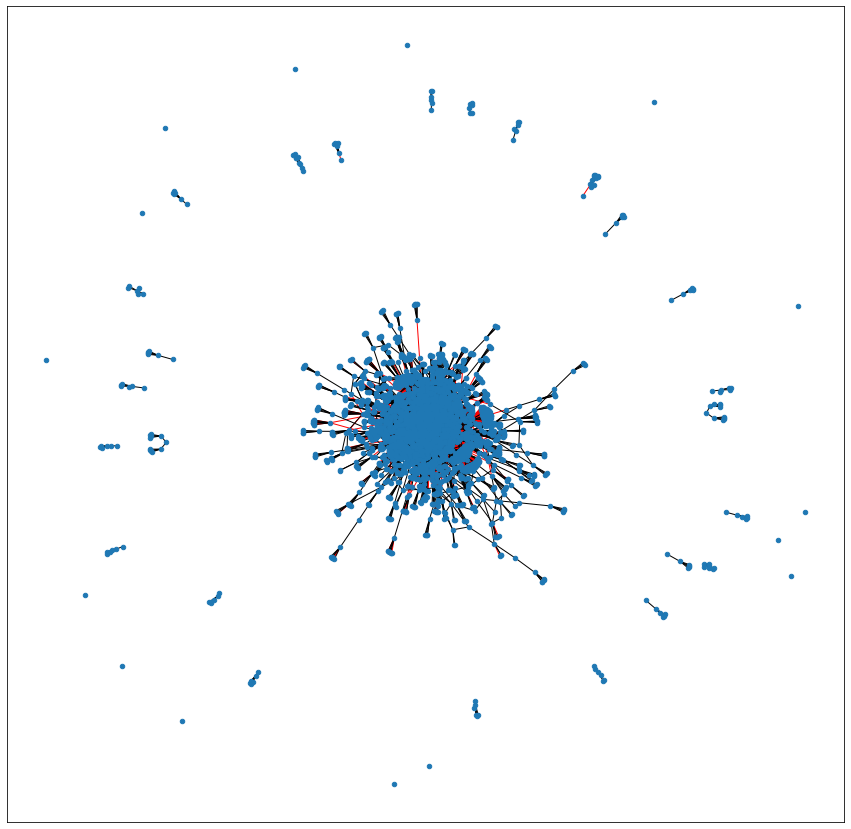

In [30]:
# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 20)
nx.draw_networkx_edges(G, pos, edgelist=ppi_edges, edge_color='r', arrows=False)
nx.draw_networkx_edges(G, pos, edgelist=gene_edges, arrows=False)
plt.show()

In [32]:
from pyvis.network import Network


In [92]:
nt = Network(width="100%", height = "1000px", notebook=True)
nt.from_nx(G)
nt.show("graph.html")